# Automated ML for time series predicion

We used one of the dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, i.e. NYC taxi passengers dataset, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot. 

In [1]:
%load_ext autoreload
%autoreload 2

## 0. Helper function definations

In [2]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# plot results of multi step forecasting
# plot at most five values for better view
# plot the predicted values and actual values (for the test data)
def plot_less_five_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(min(pred_df.shape[1] - 1, 5))]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
    plot_color = ["g", "r", "c", "m", "y"]
    for i in range(len(value_cols)):
        pred_value = pred_df[value_cols[i]].values
        pred_dt = pred_df[dt_col].values + time_delta * i
        axs.plot(pred_dt, pred_value, color=plot_color[i], label='predicted values' + str(i))

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
# plot results of multi step forecasting
# plot result of multi step forecasting
# plot the predicted values and actual values (for the test data)
def plot_first_last_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(pred_df.shape[1] - 1)]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
  
    pred_value_first = pred_df[value_cols[0]].values
    pred_dt_first = pred_df[dt_col].values
    axs.plot(pred_dt_first, pred_value_first, color="g", label='first predicted values')
 
    pred_value_last = pred_df[value_cols[-1]].values
    pred_dt_last = pred_df[dt_col].values + time_delta * (len(value_cols)-1)
    axs.plot(pred_dt_last, pred_value_last, color="r", label='last predicted values')

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

## 1. load data

In [5]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [6]:
# load nyc taxi data
try:
    dataset_path = os.getenv("ANALYTICS_ZOO_HOME")+"/bin/data/NAB/nyc_taxi/nyc_taxi.csv"
    df = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

In [7]:
# download nyc_taxi.csv
#! $ANALYTICS_ZOO_HOME/dist/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh

You can use split_input_df to split the whole dataset into train/val/test sets. There will be two columns in the output dataframe: "datetime" and "value", where the data type of "datetime" column is datetime64.

In [8]:
from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(df, val_split_ratio=0.1, test_split_ratio=0.1)

In [9]:
train_df.describe()

,value
count,8256.000000
mean,15421.585514
std,6871.989592
min,1431.000000
25%,11040.000000
50%,17014.500000
75%,20032.250000
max,39197.000000


In [10]:
train_df.head(5)

,datetime,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [11]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (8256, 2)
The shape of val_df is (1032, 2)
The shape of test_df is (1032, 2)


No handles with labels found to put in legend.


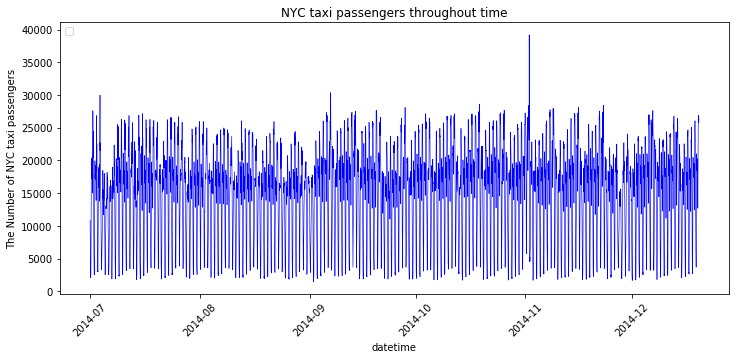

In [12]:
# visualisation of anomaly throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(train_df['datetime'], train_df['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

## 2. Train and validation

You can use analytices zoo automl to predict time series data by simply define a `TimeSequencePredictor`. 

We use feature tools to generate features from the given datetime. The generated features are \['HOUR', 'DAY', 'MONTH'. 'IS_AWAKE', 'IS_BUSY_HOURS'\]. Our feature space comprises these generated features as well as the original inputs such as \['datetime','value','extra_features'\].  

Currently, We use RNN to learn from 50 previous values, and predict just the 1 next value. You can specify the sequence length to predict while creating `TimeSequencePredictor` with arg: `future_seq_len`.

In [13]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [14]:
from zoo import init_spark_on_local
from zoo.ray import RayContext
sc = init_spark_on_local(cores=4)
ray_ctx = RayContext(sc=sc, object_store_memory="1g")
ray_ctx.init()

Current pyspark location is : /home/shan/Applications/spark-2.4.3-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
Successfully got a SparkContext
Start to launch the JVM guarding process
JVM guarding process has been successfully launched
Start to launch ray on cluster
Start to launch ray on local


In [15]:
%%time
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, GridRandomRecipe and BayesRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=RandomRecipe(look_back=(2, 4)))
print("Training completed.")

2019-12-18 15:48:56,962	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-12-18 15:48:56,962	INFO tune.py:223 -- Starting a new experiment.


Model selection: Vanilla LSTM model is selected.
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 28.9/67.4 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 28.9/67.4 GB
Result logdir: /home/shan/ray_results/automl
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - train_func_0_batch_size=1024,dropout=0.48112,dropout_1=0.26833,dropout_2=0.39814,latent_dim=32,lr=0.0080377,lstm_1_units=64,lstm_2_units=8,past_seq_len=3,selected_features=['HOUR(datetime)' 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)']:	RUNNING

(pid=7206) Prepending /home/shan/anaconda2/envs/ray36/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=7207) Prepending /home/shan/anaconda2/envs/ray36/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=7230) Prepending /home/shan/anaconda2

(pid=7207)[0
(pid=7207) 6144/8253 [=====================>........] - ETA: 0s - loss: 0.1716 - mean_squared_error: 0.1716
(pid=7207)[0
(pid=7207) 6144/8253 [=====================>........] - ETA: 0s - loss: 0.1716 - mean_squared_error: 0.1716
(pid=7207)[0
(pid=7207) 8253/8253 [==============================] - 0s 31us/step - loss: 0.1715 - mean_squared_error: 0.1715 - val_loss: 0.2062 - val_mean_squared_error: 0.2062
(pid=7207)[0
(pid=7207) 8253/8253 [==============================] - 0s 31us/step - loss: 0.1715 - mean_squared_error: 0.1715 - val_loss: 0.2062 - val_mean_squared_error: 0.2062
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 29.5/67.4 GB
Result logdir: /home/shan/ray_results/automl
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - train_func_0_batch_size=1024,dropout=0.48112,dropout_1=0.26833,dropout_2=0.39814,latent_dim=32,lr=0.0080377,lstm_1_units=64,lstm_2_units=8,past_s

(pid=7207)[0
(pid=7207) 6144/8253 [=====================>........] - ETA: 0s - loss: 0.1257 - mean_squared_error: 0.1257
(pid=7207)[0
(pid=7207) 6144/8253 [=====================>........] - ETA: 0s - loss: 0.1257 - mean_squared_error: 0.1257
(pid=7207)[0
(pid=7207) 8192/8253 [============================>.] - ETA: 0s - loss: 0.1245 - mean_squared_error: 0.12
(pid=7207) 8253/8253 [==============================] - 0s 27us/step - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.0532 - val_mean_squared_error: 0.0532
(pid=7207) Epoch 2/5
(pid=7207) 
(pid=7207) 1024/8253 [==>...........................] - ETA: 0s - loss: 0.1366 - mean_squared_error: 0.1366
(pid=7207)[0
(pid=7207) 8192/8253 [============================>.] - ETA: 0s - loss: 0.1245 - mean_squared_error: 0.12
(pid=7207) 8253/8253 [==============================] - 0s 27us/step - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.0532 - val_mean_squared_error: 0.0532
(pid=7207) Epoch 2/5
(pid=7207) 
(pid=7207) 1

(pid=7207)[0
(pid=7207) 8253/8253 [==============================] - 0s 26us/step - loss: 0.1122 - mean_squared_error: 0.1122 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
(pid=7207) Epoch 3/5
(pid=7207) 
(pid=7207) 1024/8253 [==>...........................] - ETA: 0s - loss: 0.1208 - mean_squared_error: 0.1208
(pid=7207)[0
(pid=7207) 8253/8253 [==============================] - 0s 26us/step - loss: 0.1122 - mean_squared_error: 0.1122 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
(pid=7207) Epoch 3/5
(pid=7207) 
(pid=7207) 1024/8253 [==>...........................] - ETA: 0s - loss: 0.1208 - mean_squared_error: 0.1208
(pid=7207)[0
(pid=7207) 3072/8253 [==========>...................] - ETA: 0s - loss: 0.1276 - mean_squared_error: 0.1276
(pid=7207)[0
(pid=7207) 3072/8253 [==========>...................] - ETA: 0s - loss: 0.1276 - mean_squared_error: 0.1276
(pid=7207)[0
(pid=7207) 5120/8253 [=================>............] - ETA: 0s - loss: 0.1227 - mean_squared_error: 0

(pid=7207)[0
(pid=7207) 5120/8253 [=================>............] - ETA: 0s - loss: 0.1180 - mean_squared_error: 0.1180
(pid=7207)[0
(pid=7207) 8192/8253 [============================>.] - ETA: 0s - loss: 0.1102 - mean_squared_error: 0.1102
(pid=7207)[0
(pid=7207) 8192/8253 [============================>.] - ETA: 0s - loss: 0.1102 - mean_squared_error: 0.11
(pid=7207) 8253/8253 [==============================] - 0s 29us/step - loss: 0.1109 - mean_squared_error: 0.1109 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
(pid=7207) Epoch 4/5
(pid=7207)[0
(pid=7207) 8253/8253 [==============================] - 0s 29us/step - loss: 0.1109 - mean_squared_error: 0.1109 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
(pid=7207) Epoch 4/5
(pid=7207) 
(pid=7207) 1024/8253 [==>...........................] - ETA: 0s - loss: 0.1275 - mean_squared_error: 0.1275
(pid=7207) 
(pid=7207) 1024/8253 [==>...........................] - ETA: 0s - loss: 0.1275 - mean_squared_error: 0.1275
(pid=7207)

## 3. Test

In [16]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [17]:
pred_df.head(5)

,datetime,value
0,2015-01-10 13:30:00,22192.162109
1,2015-01-10 14:00:00,21757.605469
2,2015-01-10 14:30:00,20591.683594
3,2015-01-10 15:00:00,21799.269531
4,2015-01-10 15:30:00,22432.207031


In [18]:
# prediction value start from 50
test_df[50:55]

,datetime,value
50,2015-01-11 13:00:00,21296
51,2015-01-11 13:30:00,20381
52,2015-01-11 14:00:00,19508
53,2015-01-11 14:30:00,19210
54,2015-01-11 15:00:00,18255


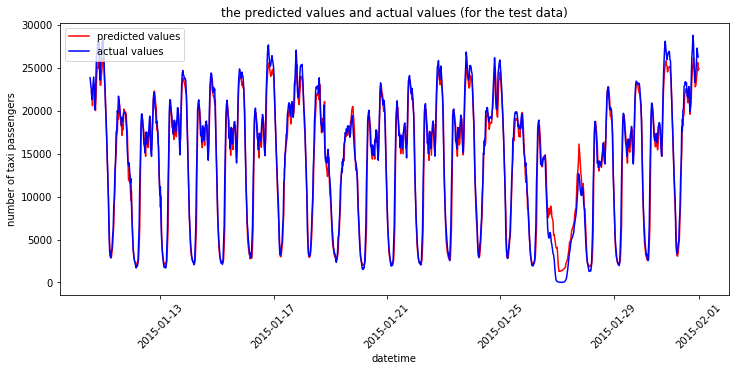

In [19]:
# plot the predicted values and actual values
plot_result(test_df, pred_df)

In [20]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 1921356.3949139877
Evaluate: the smape value is 6.465159906962593


## 4. save and restore

We provide save and restore interface to save the pipeline with the best trial for easily rebuilding.

In [21]:
# save the pipeline with best trial
pipeline.save("/tmp/saved_pipeline/my.ppl")

Pipeline is saved in /tmp/saved_pipeline/my.ppl


'/tmp/saved_pipeline/my.ppl'

In [22]:
from zoo.automl.pipeline.time_sequence import load_ts_pipeline
new_pipeline = load_ts_pipeline("/tmp/saved_pipeline/my.ppl")

Restore pipeline from /tmp/saved_pipeline/my.ppl


In [23]:
# you can do predict and evaluate again
# we use test_df as input in order to compare results before and after restoration 
new_pred = new_pipeline.predict(test_df)

In [24]:
new_pred.head(5)

,datetime,value
0,2015-01-10 13:30:00,22192.162109
1,2015-01-10 14:00:00,21757.605469
2,2015-01-10 14:30:00,20591.683594
3,2015-01-10 15:00:00,21799.269531
4,2015-01-10 15:30:00,22432.207031


In [25]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 1921356.3949139877
Evaluate: the smape value is 6.465159906962593


## 5. continue training

We support continue training with incremental data using the best configuration searched and the trained model.

In [26]:
# review the initialization infomation if needed
new_pipeline.describe()

**** Initialization info ****
future_seq_len: 1
dt_col: datetime
target_col: value
extra_features_col: None
drop_missing: True



In [27]:
# Use val_df as incremental data
new_pipeline.fit(val_df,epoch_num=5)

Epoch 1/5
1029/1029 [==============================] - 1s 1ms/step - loss: 0.1201 - mean_squared_error: 0.1201
Epoch 2/5
1029/1029 [==============================] - 0s 45us/step - loss: 0.1232 - mean_squared_error: 0.1232
Epoch 3/5
1029/1029 [==============================] - 0s 46us/step - loss: 0.1343 - mean_squared_error: 0.1343
Epoch 4/5
1029/1029 [==============================] - 0s 58us/step - loss: 0.1122 - mean_squared_error: 0.1122
Epoch 5/5
1029/1029 [==============================] - 0s 48us/step - loss: 0.1186 - mean_squared_error: 0.1186
Fit done!


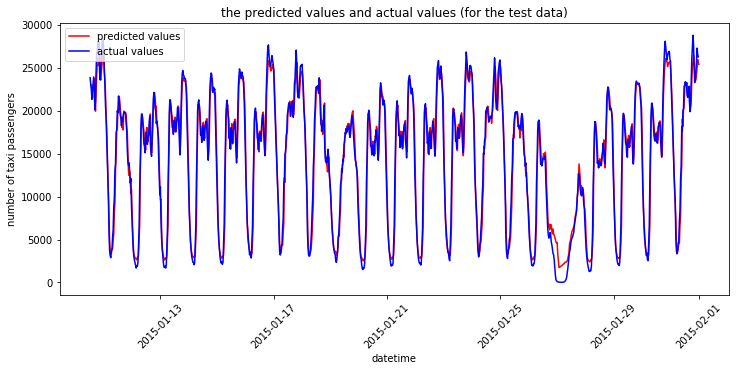

In [28]:
# predict results of test_df
new_pred_df = new_pipeline.predict(test_df)
plot_result(test_df, new_pred_df)

In [29]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 1972492.7909922532
Evaluate: the smape value is 6.915714915664744


## 6. multi step forecasting 

You can do multi step forecasting by simply changing the `future_seq_len` option while creating a new `TimeSequencePredictor` object.

In [30]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# change future_seq_len into the step you want to forcast.
tsp = TimeSequencePredictor(future_seq_len=5,
                            dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [31]:
%%time
# you can specify the look back sequence length with a single number or a range of (min_len, max_len) in RandomRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=RandomRecipe(look_back=10))
print("Training completed.")

2019-12-18 15:49:28,951	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-12-18 15:49:28,952	INFO tune.py:223 -- Starting a new experiment.


Model selection: LSTM Seq2Seq model is selected.
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 29.3/67.4 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 29.3/67.4 GB
Result logdir: /home/shan/ray_results/automl
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - train_func_0_batch_size=1024,dropout=0.21806,dropout_1=0.49144,dropout_2=0.45671,latent_dim=32,lr=0.0086638,lstm_1_units=64,lstm_2_units=128,selected_features=['WEEKDAY(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'IS_WEEKEND(datetime)']:	RUNNING

(pid=7230) Model selection: LSTM Seq2Seq model is selected.
(pid=7230) 2019-12-18 15:49:29,521	WARNING worker.py:204 -- Calling ray.get or ray.wait in a separate thread may lead to deadlock if the main thread blocks on this thread and there are not enough resources to execute more tasks
(pid

(pid=7230)[0
(pid=7230) 8192/8242 [============================>.] - ETA: 0s - loss: 0.1362 - mean_squared_error: 0.13
(pid=7230) 8242/8242 [==============================] - 0s 28us/step - loss: 0.1363 - mean_squared_error: 0.1363 - val_loss: 0.1758 - val_mean_squared_error: 0.1758
(pid=7230) Epoch 5/5
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.1291 - mean_squared_error: 0.1291
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.1291 - mean_squared_error: 0.1291
(pid=7230)[0
(pid=7230) 3072/8242 [==========>...................] - ETA: 0s - loss: 0.1414 - mean_squared_error: 0.1414
(pid=7230)[0
(pid=7230) 3072/8242 [==========>...................] - ETA: 0s - loss: 0.1414 - mean_squared_error: 0.1414
(pid=7230)[0
(pid=7230) 5120/8242 [=================>............] - ETA: 0s - loss: 0.1385 - mean_squared_error: 0.1385
(pid=7230)[0
(pid=7230) 5120/8242 [=================>............] - ETA: 0s - loss: 0.

(pid=7230)[0
(pid=7230) 6144/8242 [=====================>........] - ETA: 0s - loss: 0.0688 - mean_squared_error: 0.0688
(pid=7230)[0
(pid=7230) 6144/8242 [=====================>........] - ETA: 0s - loss: 0.0688 - mean_squared_error: 0.0688
(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 24us/step - loss: 0.0806 - mean_squared_error: 0.0806 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
(pid=7230) Train on 8242 samples, validate on 1018 samples
(pid=7230) Epoch 1/5
(pid=7230) WARNING:tensorflow:Layer decoder_lstm was passed non-serializable keyword arguments: {'training': None, 'initial_state': [<tf.Tensor 'encoder_lstm/while/Exit_2:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'encoder_lstm/while/Exit_3:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 24us/step - loss: 0.0806 - mean_squared_error

(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 36us/step - loss: 0.0644 - mean_squared_error: 0.0644 - val_loss: 0.1157 - val_mean_squared_error: 0.1157
(pid=7230) Train on 8242 samples, validate on 1018 samples
(pid=7230) Epoch 1/5
(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 36us/step - loss: 0.0644 - mean_squared_error: 0.0644 - val_loss: 0.1157 - val_mean_squared_error: 0.1157
(pid=7230) Train on 8242 samples, validate on 1018 samples
(pid=7230) Epoch 1/5
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0674 - mean_squared_error: 0.0674
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0674 - mean_squared_error: 0.0674
(pid=7230)[0
(pid=7230) 3072/8242 [==========>...................] - ETA: 0s - loss: 0.0601 - mean_squared_error: 0.0601
(pid=7230)[0
(pid=7230) 3072/8242 [==========>...................] - ETA: 0s - loss: 0.0601 - mean_squared_error: 0.060

(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0411 - mean_squared_error: 0.0411
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0411 - mean_squared_error: 0.0411
(pid=7230)[0
(pid=7230) 3072/8242 [==========>...................] - ETA: 0s - loss: 0.0413 - mean_squared_error: 0.0413
(pid=7230)[0
(pid=7230) 3072/8242 [==========>...................] - ETA: 0s - loss: 0.0413 - mean_squared_error: 0.0413
(pid=7230)[0
(pid=7230) 5120/8242 [=================>............] - ETA: 0s - loss: 0.0431 - mean_squared_error: 0.0431
(pid=7230)[0
(pid=7230) 5120/8242 [=================>............] - ETA: 0s - loss: 0.0431 - mean_squared_error: 0.0431
(pid=7230)[0
(pid=7230) 7168/8242 [=========================>....] - ETA: 0s - loss: 0.0467 - mean_squared_error: 0.0467
(pid=7230)[0
(pid=7230) 7168/8242 [=========================>....] - ETA: 0s - loss: 0.0467 - mean_squared_error: 0.0467
(pid=7230)[0
(pid=7230) 819

(pid=7230)[0
(pid=7230) 4096/8242 [=============>................] - ETA: 0s - loss: 0.0349 - mean_squared_error: 0.0349
(pid=7230)[0
(pid=7230) 7168/8242 [=========================>....] - ETA: 0s - loss: 0.0374 - mean_squared_error: 0.0374
(pid=7230)[0
(pid=7230) 7168/8242 [=========================>....] - ETA: 0s - loss: 0.0374 - mean_squared_error: 0.0374
(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 23us/step - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0803 - val_mean_squared_error: 0.0803
(pid=7230) Epoch 2/5
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0529 - mean_squared_error: 0.0529
(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 23us/step - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0803 - val_mean_squared_error: 0.0803
(pid=7230) Epoch 2/5
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0529 - mean_squared_error: 0

(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 24us/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
(pid=7230) Epoch 3/5
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0397 - mean_squared_error: 0.0397
(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 24us/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
(pid=7230) Epoch 3/5
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0397 - mean_squared_error: 0.0397
(pid=7230)[0
(pid=7230) 3072/8242 [==========>...................] - ETA: 0s - loss: 0.0370 - mean_squared_error: 0.0370
(pid=7230)[0
(pid=7230) 3072/8242 [==========>...................] - ETA: 0s - loss: 0.0370 - mean_squared_error: 0.0370
(pid=7230)[0
(pid=7230) 6144/8242 [=====================>........] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0

(pid=7230)[0
(pid=7230) 5120/8242 [=================>............] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336
(pid=7230)[0
(pid=7230) 5120/8242 [=================>............] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336
(pid=7230)[0
(pid=7230) 7168/8242 [=========================>....] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342
(pid=7230)[0
(pid=7230) 7168/8242 [=========================>....] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342
(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 38us/step - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0711 - val_mean_squared_error: 0.0711
(pid=7230) Epoch 4/5
(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 38us/step - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0711 - val_mean_squared_error: 0.0711
(pid=7230) Epoch 4/5
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0329 - mean_squared_error:

(pid=7230)[0
(pid=7230) 4096/8242 [=============>................] - ETA: 0s - loss: 0.0324 - mean_squared_error: 0.0324
(pid=7230)[0
(pid=7230) 4096/8242 [=============>................] - ETA: 0s - loss: 0.0324 - mean_squared_error: 0.0324
(pid=7230)[0
(pid=7230) 6144/8242 [=====================>........] - ETA: 0s - loss: 0.0311 - mean_squared_error: 0.0311
(pid=7230)[0
(pid=7230) 6144/8242 [=====================>........] - ETA: 0s - loss: 0.0311 - mean_squared_error: 0.0311
(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 23us/step - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0789 - val_mean_squared_error: 0.0789
(pid=7230) Epoch 4/5
(pid=7230)[0
(pid=7230) 8242/8242 [==============================] - 0s 23us/step - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0789 - val_mean_squared_error: 0.0789
(pid=7230) Epoch 4/5
(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0303 - mean_squared_error:

(pid=7230) 
(pid=7230) 1024/8242 [==>...........................] - ETA: 0s - loss: 0.0469 - mean_squared_error: 0.0469
(pid=7230)[0
(pid=7230) 4096/8242 [=============>................] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335
(pid=7230)[0
(pid=7230) 4096/8242 [=============>................] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335
(pid=7230)[0
(pid=7230) 7168/8242 [=========================>....] - ETA: 0s - loss: 0.0290 - mean_squared_error: 0.0290
(pid=7230)[0
(pid=7230) 7168/8242 [=========================>....] - ETA: 0s - loss: 0.0290 - mean_squared_error: 0.0290
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 29.4/67.4 GB
Result logdir: /home/shan/ray_results/automl
Number of trials: 1 ({'TERMINATED': 1})
TERMINATED trials:
 - train_func_0_batch_size=1024,dropout=0.21806,dropout_1=0.49144,dropout_2=0.45671,latent_dim=32,lr=0.0086638,lstm_1_units=64,lstm_2_un

In [32]:
# test
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [33]:
pred_df.head(5)

,datetime,value_0,value_1,value_2,value_3,value_4
0,2015-01-10 17:00:00,20544.215887,20488.975324,20003.972263,19217.881677,18247.222892
1,2015-01-10 17:30:00,21114.137920,20863.955988,20218.575409,19284.430270,18182.702733
2,2015-01-10 18:00:00,23327.051782,22636.173674,21635.037599,20404.316844,19071.609196
3,2015-01-10 18:30:00,24770.840995,23813.619430,22561.436395,21156.500540,19719.400959
4,2015-01-10 19:00:00,25104.992497,24141.002251,22834.490373,21386.294104,19924.729628


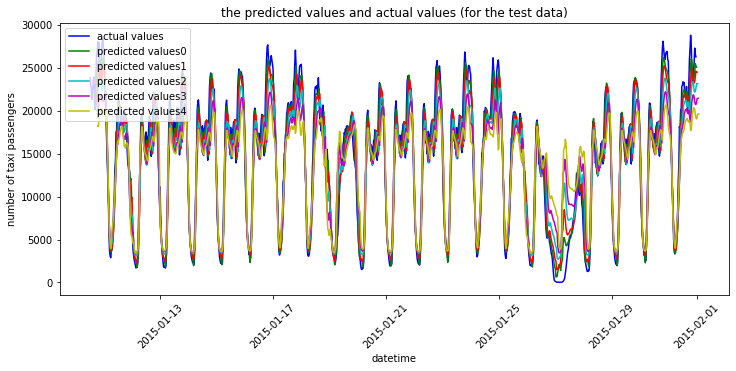

In [34]:
# plot multi step predicted values and actual values
# plot at most five step predict values for better view
plot_less_five_step_result(test_df, pred_df)

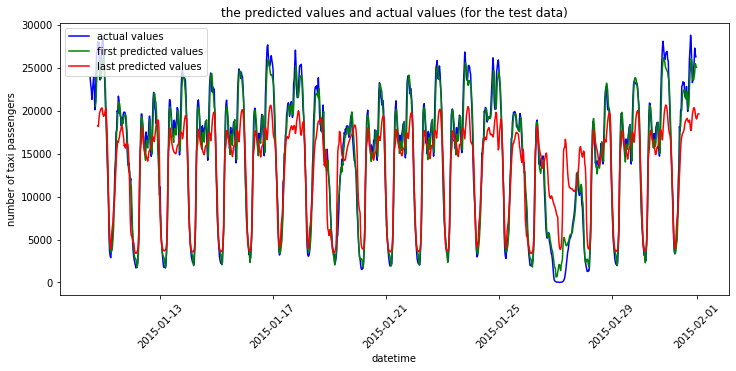

In [35]:
# plot only the first and the last step predict values and actual values
plot_first_last_step_result(test_df, pred_df)

In [36]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is [ 1741473.00570013  4340678.51999395  7704365.03016982 11124998.65989569
 14944043.70242228]
Evaluate: the smape value is [ 6.317403    8.62655514 10.83740387 12.11209905 12.92543761]


In [37]:
ray_ctx.stop()

Stopping pgids: [7181, 7220]
Stopping by pgid 7181
Stopping by pgid 7220
